#Week 6: Image segmentation, level sets, active contours

https://github.com/burakbayramli/classnotes/tree/master/pde/pde_level

http://ascratchpad.blogspot.com/2011/01/level-sets-and-image-segmentation-with.html

In [42]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

import cv2
import scipy.ndimage.filters

## The image to segment

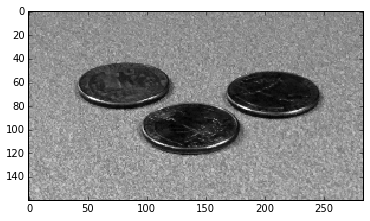

In [154]:
# use coins
img_name = 'images/coins_ellipse.jpg'
img_color = cv2.imread(img_name)
#scale & convert to grays
v_scaling = 160./img_color.shape[0]
h_scaling = v_scaling #80./img_color.shape[1]
img_color_scaled = cv2.resize(img_color, dsize=(0,0), fx=h_scaling, fy=v_scaling)
img = cv2.cvtColor(img_color_scaled, cv2.COLOR_BGR2GRAY).astype(np.float)

imgplt = plt.imshow(img, cmap=cm.Greys_r, interpolation="nearest")

##Create edge stopper

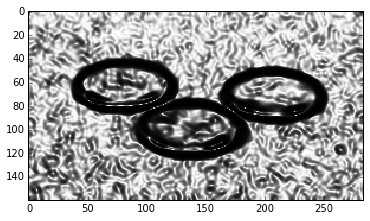

In [155]:
img_smooth =  scipy.ndimage.filters.gaussian_filter(img, 2)

grad_img_smooth = np.gradient(img_smooth)
grad_img_smooth_abs = np.sqrt(grad_img_smooth[1]**2 + grad_img_smooth[0]**2)
g = 1 / (1 + grad_img_smooth_abs**2)

imgplt = plt.imshow(g, cmap=cm.Greys_r, interpolation="nearest")

##Create initial phi

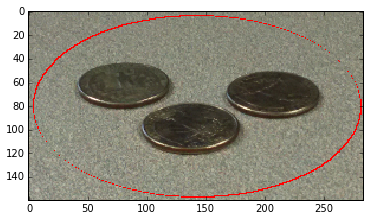

In [156]:
# Create Square
h, w = img.shape
c0 =  1.0
w0 = 4
phi0 = -c0 * np.ones((h, w))
cv2.ellipse(phi0, center=(w/2, h/2), axes=(w/2-w0, h/2-w0), angle=0, startAngle=0, endAngle=360,color=c0, thickness=-1)

# contour funtion
def contour(phi):
    sign = np.sign(phi)
    sign[sign == 0] = 1
    sign[1:, 1:] = (1 - sign[1:,1:] * sign[:-1,:-1])/2
    sign[:, :1] = 0
    sign[:1, :] = 0
    return sign

# Create image with contour
def show_shapes(img_color, phi):
    #imgplt = plt.imshow(phi0, cmap='gray', interpolation="nearest")
    c = cv2.resize(contour(phi), dsize=(img_color.shape[1], img_color.shape[0]))
    i = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    i[np.where(c != 0)] = (255,0,0)
    #imgplt = plt.imshow(c[:50,:50], cmap='gray', interpolation="nearest")
    imgplt = plt.imshow(i, interpolation="nearest")
    return i
    
imgplt = plt.imshow(show_shapes(img_color_scaled, phi0), interpolation="nearest")

##dphi/dt

In [157]:
def dphi_dt(phi, motion='curvature', g=1):
    # Gradient
    grad = np.gradient(phi)
    grad_abs = np.sqrt(grad[0]**2 + grad[1]**2)
    # Norm.
    norm = grad/(grad_abs + (grad_abs==0))
    # Divergence
    div = np.gradient(norm[0])[0] + np.gradient(norm[1])[1]
    # Curvature.
    k = div   
    
    k_term = g * k * grad_abs
    const_term = -1 *g * grad_abs
    g_term = np.gradient(g)[0] * grad[0]  + np.gradient(g)[1] * grad[1]
    
    dPhiBydT = k_term + const_term + g_term  
    return dPhiBydT 


##Iterate

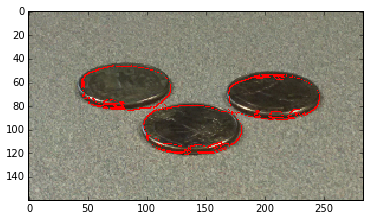

In [158]:
n_iter = 300
iter_capture = 5
phi = phi0.copy()
dt = 1.

img_sequence = []

for i in range(n_iter):
    phi = phi + dt * dphi_dt(phi, g= g*np.ones_like(phi))
    # frame capture
    if i % iter_capture == 0:
        img_sequence.append(show_shapes(img_color_scaled, phi))

imgplt = plt.imshow(img_sequence[-1], interpolation="nearest")

##Write animated GIF
`images2gif` from: https://github.com/rec/echomesh/blob/master/code/python/external/images2gif.py


In [153]:
from images2gif import writeGif
gif_out = img_name.replace('.jpg', '_segment_animated.gif')
writeGif(gif_out, img_sequence, duration=.25)

##And the Result:
![A](https://raw.githubusercontent.com/rmetchev/IVP-Python/master/images/coins_ellipse_segment_animated.gif)